In [1]:
import math
import numpy as np
import pandas as pd
from datetime import datetime as dt

from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA

import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15,6

In [2]:
file_path = r"C:\Users\12489\Documents\Data\monthly-beer-prod-aussie.csv"

df = pd.read_csv(file_path)

df.head()

,Month,Monthly beer production in Australia
0,1956-01,93.2
1,1956-02,96.0
2,1956-03,95.2
3,1956-04,77.1
4,1956-05,70.9


In [3]:
df.info()

# no null values... great!

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 476 entries, 0 to 475
Data columns (total 2 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Month                                 476 non-null    object 
 1   Monthly beer production in Australia  476 non-null    float64
dtypes: float64(1), object(1)
memory usage: 7.6+ KB


--------------------------------

### let's make sure the 'Month' column has appropriate datetime syntax... (and set it to the index)

In [4]:
df['Month'] = df['Month'].apply(lambda x: dt(int(x[:4]), int(x[5:]), 1))

"""since day results were gathered wasn't specified, 
I am just going to choose the first"""

df = df.set_index('Month')
df.head()

,Monthly beer production in Australia
Month,
1956-01-01,93.2
1956-02-01,96.0
1956-03-01,95.2
1956-04-01,77.1
1956-05-01,70.9


------------------------------------

### now that datetime is the index, we can take our first look at the raw data

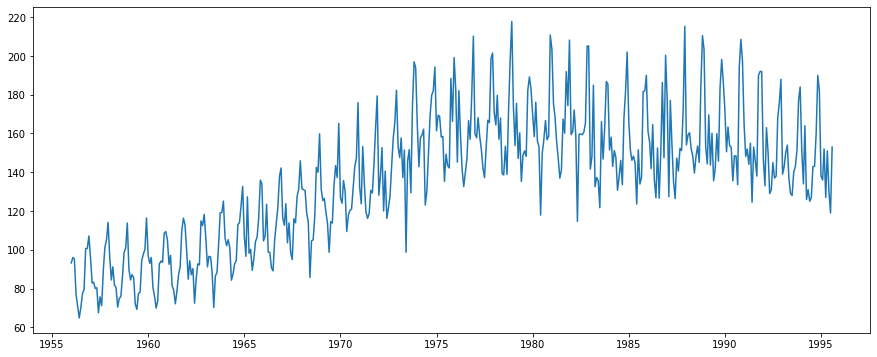

In [6]:
ts = df['Monthly beer production in Australia']

plt.plot(ts)

--------------------------------------------

### "Check for the stationarity of your data using Rolling Statistics and Dickey-Fuller test."

In [8]:
ts_log = np.log(ts)

In [10]:
def check_stationarity(timeseries):
    roll_mean = timeseries.rolling(window=52, center=False).mean()
    roll_stDev = timeseries.rolling(window=52, center=False).std()

    plt.plot(timeseries, color='blue', label='Original')
    plt.plot(roll_mean, color='red', label='Rolling Mean')
    plt.plot(roll_stDev, color='black', label='Rolling St.Dev')

    plt.legend(loc='best')
    plt.title("Rolling Mean & Standard Deviation")
    plt.show(block=False)

    print("Results of Dickey-Fuller Test:")
    dFull_test = adfuller(timeseries, autolag='AIC')
    dFull_output = pd.Series(dFull_test[:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])

    for key, value in dFull_test[4].items():
        dFull_output['Critical Value (%s)'%key] = value

    print(dFull_output)

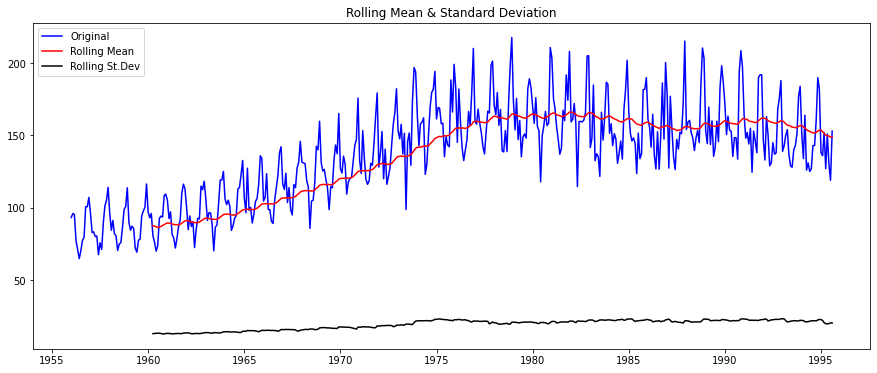

Results of Dickey-Fuller Test:
Test Statistic                  -2.282661
p-value                          0.177621
#Lags Used                      17.000000
Number of Observations Used    458.000000
Critical Value (1%)             -3.444709
Critical Value (5%)             -2.867871
Critical Value (10%)            -2.570142
dtype: float64


In [11]:
check_stationarity(df['Monthly beer production in Australia'])

#### Test Statistic: -2.28
#### Critical Value (1% to 10%): -3.44 to -2.57

### **since the "stats" are outside the range, we should try removing the difference**
----------------------------------

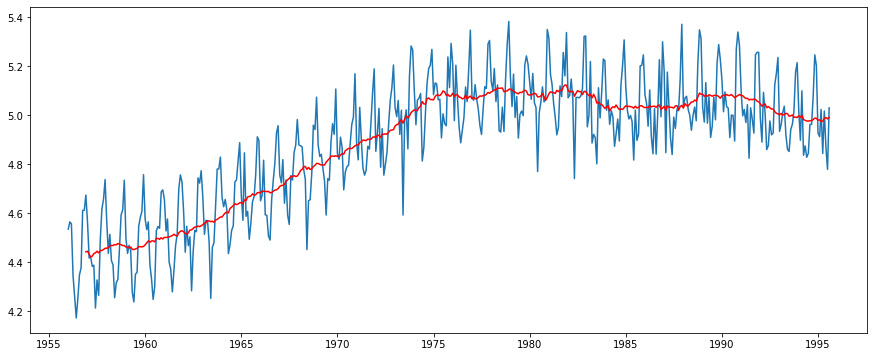

In [13]:
movingMean = ts_log.rolling(window=12).mean()
plt.plot(ts_log)
plt.plot(movingMean, color = 'red')

In [14]:
ts_log_mv_diff = ts_log - movingMean

ts_log_mv_diff.dropna(inplace=True)
ts_log_mv_diff.head()

Month
1956-12-01    0.231830
1957-01-01    0.118994
1957-02-01   -0.015558
1957-03-01    0.001590
1957-04-01   -0.041908
Name: Monthly beer production in Australia, dtype: float64

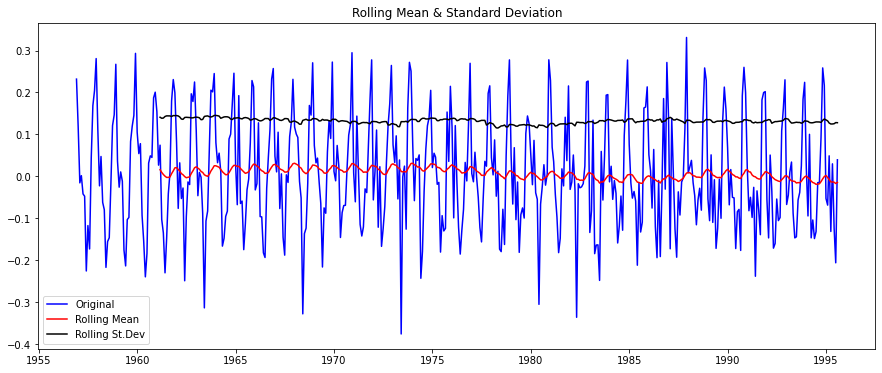

Results of Dickey-Fuller Test:
Test Statistic                  -3.432559
p-value                          0.009898
#Lags Used                      13.000000
Number of Observations Used    451.000000
Critical Value (1%)             -3.444933
Critical Value (5%)             -2.867970
Critical Value (10%)            -2.570195
dtype: float64


In [15]:
test_stationarity(ts_log_mv_diff)

#### Test Statistic: -3.43
#### Critical Value (1% to 10%): -3.44 to -2.57

### **since "stats" are within the range, we can reject Null Hypothesis**